# Comparison with state of the art

In [1]:
from functions import *
from UNET import *
from resnet_functions import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device

dataset_path = "./Dataset/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
numpy_path = "./augmented_dataset"
torch.manual_seed(8524011162127527122)
np.random.seed(123456789)


In [3]:
dataset = load_dataset(numpy_path)

./augmented_dataset


In [4]:
training_set, validation_set, testing_set = random_split(dataset, (0.8, 0.1, 0.1))
print(len(training_set), len(validation_set), len(testing_set))
print(training_set[0].shape, validation_set[0].shape, testing_set[0].shape)

1477 184 184
(5, 16, 240, 240) (5, 16, 240, 240) (5, 16, 240, 240)


In [5]:
processed_training_set = split_layers(np.array(training_set))
processed_validation_set = split_layers(np.array(validation_set))
processed_testing_set = split_layers(np.array(testing_set))

In [6]:
print(processed_training_set.shape, processed_validation_set.shape, processed_testing_set.shape)
print(type(processed_testing_set))

(23632, 5, 240, 240) (2944, 5, 240, 240) (2944, 5, 240, 240)
<class 'numpy.ndarray'>


In [7]:
resized_dim = 120

resize_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((resized_dim, resized_dim)),
    transforms.ToTensor(),
])

def resize_images(image_np):
    image_tensor = torch.tensor(image_np,dtype= torch.float32)
    transformed = [resize_transform(image_tensor[i]).squeeze(0) for i in range(image_tensor.shape[0])]
    return torch.stack(transformed)

def resize_set(dataset_obj):
    return np.array([resize_images(dataset_obj[i]).numpy() for i in range(dataset_obj.shape[0])])

    

In [8]:
shrunk_processed_training_set = resize_set(processed_training_set)
print("shrunk processed training set")
shrunk_processed_validation_set = resize_set(processed_validation_set)
print("shrunk processed validation set")
shrunk_processed_testing_set = resize_set(processed_testing_set)
print("shrunk processed testing set")


shrunk processed training set
shrunk processed validation set
shrunk processed testing set


In [9]:
print(shrunk_processed_training_set.shape, shrunk_processed_validation_set.shape, shrunk_processed_testing_set.shape)

(23632, 5, 120, 120) (2944, 5, 120, 120) (2944, 5, 120, 120)


In [10]:
training_custom_set = CustomDataset(shrunk_processed_training_set)
validation_custom_set = CustomDataset(shrunk_processed_validation_set)
testing_custom_set = CustomDataset(shrunk_processed_testing_set)

batch_size = 80

training_dataloader = DataLoader(training_custom_set, batch_size = batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_custom_set, batch_size = batch_size, shuffle=True)
testing_dataloader = DataLoader(testing_custom_set, batch_size = batch_size ,shuffle=True)

In [11]:
print(next(iter(training_dataloader))[0].shape, next(iter(training_dataloader))[1].shape)

torch.Size([80, 4, 120, 120]) torch.Size([80, 1, 120, 120])


In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device = "mps" if torch.backends.mps.is_available() else device
model = createDeepLabv3()
model.to(device)
loss1 = dice_loss
loss2 = nn.BCEWithLogitsLoss()
epochs = 2

def combined_loss(y_pred, y_true):
    output = loss1(y_pred, y_true) + loss2(y_pred, y_true)
    return output

loss3 = combined_loss
optim = torch.optim.Adam(model.parameters(), lr=0.001)
feature_range = (0,4)

Uncomment to train manually

In [13]:
# train_loss_dice, val_loss_dice = train_model_state_of_the_art(model, train_dataloader=training_dataloader, val_dataloader=validation_dataloader, 
#                                    optimizer=optim,feature_range=feature_range, device = device, loss_fn = loss1, display_batch_loss=True, 
#                                    save_folder="Resnet_loss", epochs = epochs)

Epoch: 1 of 2
Batch: 1 of 296 Loss: 0.985065221786499
Batch: 11 of 296 Loss: 0.9522033333778381
Batch: 21 of 296 Loss: 0.9250155091285706
Batch: 31 of 296 Loss: 0.8517630100250244
Batch: 41 of 296 Loss: 0.7190748453140259
Batch: 51 of 296 Loss: 0.5984424352645874
Batch: 61 of 296 Loss: 0.4902036786079407
Batch: 71 of 296 Loss: 0.49211788177490234
Batch: 81 of 296 Loss: 0.47962629795074463
Batch: 91 of 296 Loss: 0.43598008155822754
Batch: 101 of 296 Loss: 0.42860639095306396
Batch: 111 of 296 Loss: 0.44203102588653564
Batch: 121 of 296 Loss: 0.5033925771713257
Batch: 131 of 296 Loss: 0.4039113521575928
Batch: 141 of 296 Loss: 0.5331861972808838
Batch: 151 of 296 Loss: 0.4264145493507385
Batch: 161 of 296 Loss: 0.417397677898407
Batch: 171 of 296 Loss: 0.39026618003845215
Batch: 181 of 296 Loss: 0.39768701791763306
Batch: 191 of 296 Loss: 0.38591134548187256
Batch: 201 of 296 Loss: 0.39597827196121216
Batch: 211 of 296 Loss: 0.38755232095718384
Batch: 221 of 296 Loss: 0.3404054641723633


In [16]:
model1 = torch.load("./saved_models/Resnet_loss/model_2.pth").to(device)
pred1, outputs = visualize_resnet(model1,testing_dataloader, device, feature_range = feature_range, number_gen = 20)

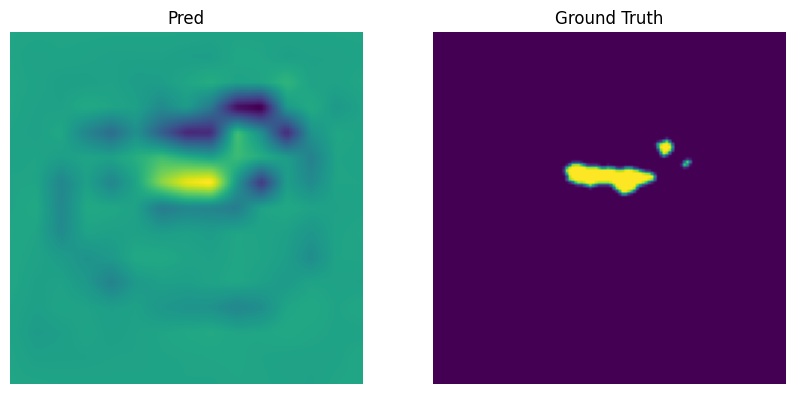

In [20]:
index = 8
display_slice(pred1[index][0][0], outputs[index][0][0], 'Pred', 'Ground Truth')

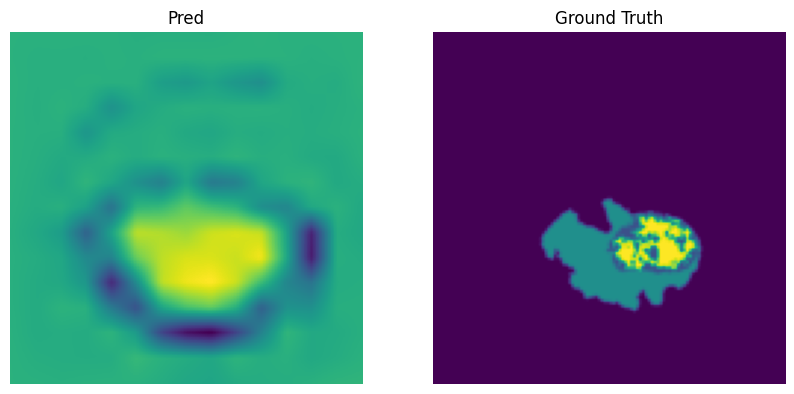

In [21]:
index = 10
display_slice(pred1[index][0][0], outputs[index][0][0], 'Pred', 'Ground Truth')